In [5]:
# PID Controller without LinearRegression

import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.linear_model import LinearRegression

df = pd.read_csv(
    "C:\\Users\\90545\\OneDrive\\Masaüstü\\LESSONS\\BITIRMEPROJESI\\ankara_temperature_2025.csv",
    parse_dates=["Timestamp"]
)
df = df.set_index("Timestamp").sort_index()

TARGET_TEMP = 20.0
Kp = 0.6
Ki = 0.05
Kd = 0.4
Ke = 0.1
MAX_CONTROL = 6.5
MIN_CONTROL = -6.5

indoor_temp = None
integral_error = 0.0
previous_time = None
results = []

# --- Döngü ---
for ts in df.index:
    outdoor_temp = df.at[ts, "Temperature (°C)"]

    if indoor_temp is None:
        indoor_temp = outdoor_temp  # ilk değer dış ortamla başlasın

    if ts - df.index[0] < timedelta(days=4):
        # İlk 4 gün: sadece dış ortamın etkisiyle iç sıcaklık güncellensin (klima kapalı gibi)
        influence_from_outdoor = 0.065 * (outdoor_temp - indoor_temp)
        indoor_temp += influence_from_outdoor

        results.append({
            "Timestamp": ts,
            "Outdoor Temp (°C)": outdoor_temp,
            "Indoor Temp (°C)": indoor_temp,
            "Control Output": 0.0
        })
        continue

    # Geçmiş 4 günün aynı saatindeki iç sıcaklıklar
    past_days_indoor = []
    for days_ago in range(1, 5):
        past_ts = ts - timedelta(days=days_ago)
        close_result = next(
            (r for r in reversed(results)
             if r["Timestamp"].hour == ts.hour and r["Timestamp"].date() == past_ts.date()),
            None
        )
        if close_result:
            past_days_indoor.append(close_result["Indoor Temp (°C)"])

    if len(past_days_indoor) < 4:
        continue

    recent_indoor_temps = [r["Indoor Temp (°C)"] for r in results[-4:]]

    error = TARGET_TEMP - indoor_temp
    trend = np.mean(recent_indoor_temps) - np.mean(past_days_indoor)
    external_effect = outdoor_temp - TARGET_TEMP

    if previous_time is not None:
        delta_t = (ts - previous_time).total_seconds() / 60
    else:
        delta_t = 1
    previous_time = ts

    integral_error += error * delta_t
    integral_error = max(min(integral_error, 100), -100)

    control_output = (
        Kp * error
        - Kd * trend
        - Ke * external_effect
        + Ki * integral_error
    )
    control_output = max(min(control_output, MAX_CONTROL), MIN_CONTROL)

    influence_from_outdoor = 0.065 * (outdoor_temp - indoor_temp)
    influence_from_ac = 0.2 * control_output
    indoor_temp += influence_from_outdoor + influence_from_ac

    results.append({
        "Timestamp": ts,
        "Outdoor Temp (°C)": outdoor_temp,
        "Indoor Temp (°C)": indoor_temp,
        "Control Output": control_output
    })

res_df = pd.DataFrame(results).set_index("Timestamp")

np.random.seed(42)
random_timestamps = res_df.resample("6H").first().dropna().sample(3).index
sample_slices = [res_df.loc[ts:ts + timedelta(hours=1)] for ts in random_timestamps]
samples_df = pd.concat(sample_slices)

print("🔍 İlk 10 ölçüm:")
print(res_df.head(10))

print("\n📊 Rastgele seçilen 3 zaman aralığından birer saatlik örnek:")
print(samples_df)


🔍 İlk 10 ölçüm:
                     Outdoor Temp (°C)  Indoor Temp (°C)  Control Output
Timestamp                                                               
2025-01-01 00:00:00          -7.421593         -7.421593             0.0
2025-01-01 00:15:00          -7.789700         -7.445520             0.0
2025-01-01 00:30:00          -6.701143         -7.397135             0.0
2025-01-01 00:45:00          -5.612274         -7.281119             0.0
2025-01-01 01:00:00          -6.320769         -7.218697             0.0
2025-01-01 01:15:00          -7.439611         -7.233056             0.0
2025-01-01 01:30:00          -6.543320         -7.188223             0.0
2025-01-01 01:45:00          -6.698491         -7.156391             0.0
2025-01-01 02:00:00          -5.813711         -7.069117             0.0
2025-01-01 02:15:00          -8.143630         -7.138960             0.0

📊 Rastgele seçilen 3 zaman aralığından birer saatlik örnek:
                     Outdoor Temp (°C)  Indoor 

C:\Users\90545\AppData\Local\Temp\ipykernel_8508\68751017.py:99: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  random_timestamps = res_df.resample("6H").first().dropna().sample(3).index


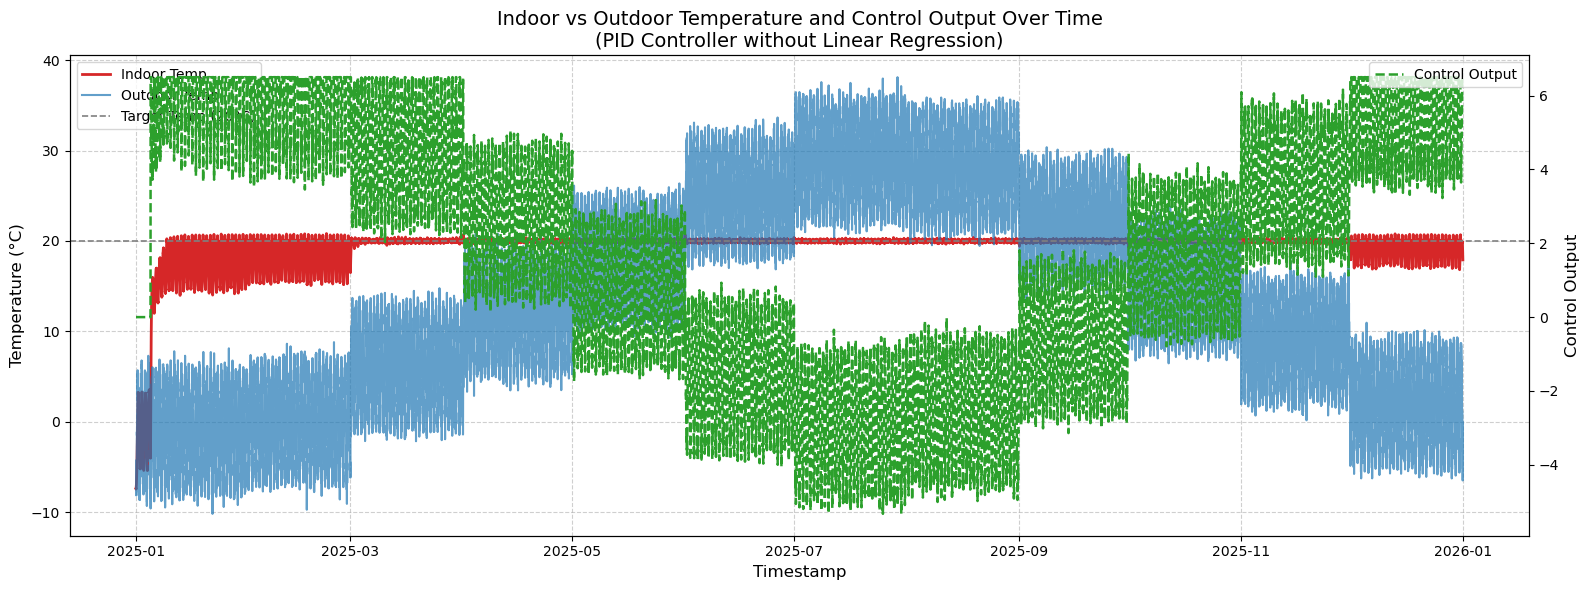

In [7]:
import matplotlib.pyplot as plt

# Ana grafik ve ilk eksen (sıcaklıklar)
fig, ax1 = plt.subplots(figsize=(16, 6))

# Indoor ve Outdoor sıcaklıkları
ax1.plot(res_df.index, res_df["Indoor Temp (°C)"], label="Indoor Temp", color="tab:red", linewidth=2)
ax1.plot(res_df.index, res_df["Outdoor Temp (°C)"], label="Outdoor Temp", color="tab:blue", linewidth=1.5, alpha=0.7)
ax1.axhline(y=TARGET_TEMP, color="gray", linestyle="--", linewidth=1.2, label="Target Temp (20°C)")

# Eksen ayarları
ax1.set_xlabel("Timestamp", fontsize=12)
ax1.set_ylabel("Temperature (°C)", fontsize=12)
ax1.legend(loc="upper left")
ax1.grid(True, linestyle="--", alpha=0.6)

# İkinci eksen (Control Output)
ax2 = ax1.twinx()
ax2.plot(res_df.index, res_df["Control Output"], label="Control Output", color="tab:green", linestyle="--", linewidth=1.8)
ax2.set_ylabel("Control Output", fontsize=12)
ax2.legend(loc="upper right")

plt.title("Indoor vs Outdoor Temperature and Control Output Over Time\n(PID Controller without Linear Regression)", fontsize=14)
plt.tight_layout()
plt.show()
